In [1]:
import os

# Set the base directory (in case you want to
# keep a notebook in a subfolder)
subdir = '/examples'
basedir = os.environ['HOME'] + subdir

os.chdir(basedir)

In [2]:
# External package imports
import matplotlib
import matplotlib.pyplot as plt

# Local package imports
from libs.GcmData.GcmDataLoaderExocam import GcmDataLoaderExocam
import libs.utils

# Adjust font size of plots with this
# matplotlib.rcParams.update({ 'font.size': 16 })

## Functions

In [3]:
def plot_atm_profile(
    data,
    f_process,
    ax,
    xlabel='',
    plot_kwargs={},
    update_axes=True
):
    '''
    Function `plot_atm_profile`

    Inputs:
    - `data`
        description: the input data to plot
        type: xarray.DataArray
    - `f_process`
        description: function which processes the data
            before plotting, such as selecting a variable,
            a latitude/longitude, taking a time slice, etc.
        type: function
    - `ax`
        description: the axis to plot on
        type: matplotlib.axes._subplots.AxesSubplot
    - `xlabel`
        description: set a label for the x-axis
        default: ''
        type: string
    - `plot_kwargs`
        description: pass in keyword arguments for the
            plotting function. See for arguments:
            https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
        default: {}
        type: dict
    - `update_axes`
        description: whether to update the axes scales and labels
        default: True
        type: bool

    Outputs:
    - `ax`
        description: the axis which has been plotted on
    - `subfig`
        description: the plotted subfigure
    '''
    # Plot the processed data `f_process(data)`
    # against the pressure coordinates `lev_p`
    # NB the use of ** 'expands' out the dictionary
    # into arguments for the plotting function
    subfig = ax.plot(
        f_process(data),
        data['lev_p'],
        **plot_kwargs
    )

    if update_axes:
        # NB pressure decreases exponentially so ensure 
        # y axis is correctly set up to reflect this
        ax.invert_yaxis()
        ax.set_yscale('log')
    
        # Label axes
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Pressure [$hPa$]')

    # Return updated ax and subfig, where we can then 
    # plot on it again or make any other changes
    return ax, subfig

In [4]:
# A dictionary of some example vertical profile variables to plot
# You can select one using the key, e.g. confs_vert_temperatures['temperature']
confs_vertical_variables = {
    'temperature': {
        'xlabel': 'Temperature [$K$]',
        'f_process': lambda data : data.ta
    },
    'lapse-rate': {
        'xlabel': 'Lapse rate [$K$ $km^{-1}$]',
        # NB 1000 * is kilo multiplier
        'f_process': lambda data: (
            1000. * data['ta'].differentiate('lev') / data['Z3'].differentiate('lev')
        )
    },
    'shortwave-heating': {
        'xlabel': 'Shortwave heating rate [$K$ $s^{-1}$]',
        'f_process': lambda data : data.tntrs
    },
    'longwave-heating': {
        'xlabel': 'Longwave heating rate [$K$ $s^{-1}$]',
        'f_process': lambda data : data.tntrl
    },
    'specific-humidity': {
        'xlabel': 'Specific humidity [$kg/kg$]',
        'f_process': lambda data : data.hus
    },
    'h2o-mixing-ratio': {
        'xlabel': '$H_{2}O$ mixing ratio',
        'f_process': lambda data : data.hus / (1 - data.hus)
    }
}

## Data

In [5]:
loader = GcmDataLoaderExocam(
    id='thai-hab1',
    path='data/{id}.cam.h0.*.nc'
)

gcm_data = loader.load()

Centering longitude
Standardising vars


In [6]:
# Average over a time slice and select central latitude 
# and longitude just for examples. Note that there is
# no grid point over latitude=0, so we take a weighted average
# across -2 to 2 degrees.
gcm_slice = gcm_data\
    .sel(
        lat=slice(-2, 2),
        lon=0,
        time=slice('0012-01-01', '0015-01-01')
    )\
    .gcm_data.weighted_lat()\
    .mean(('time', 'lat'))

## Plots

### 1x1 Temperature profile plot at a specified latitude + longitude

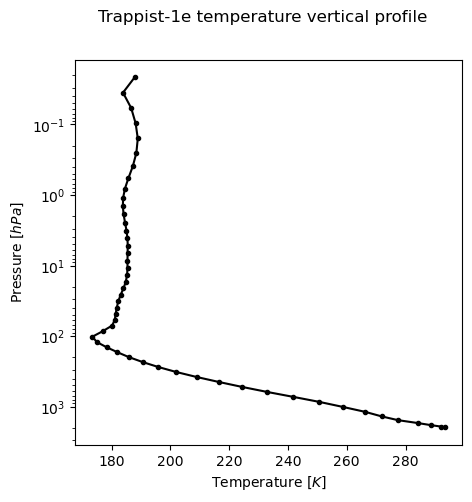

In [7]:
# Create matplotlib figure with axes
fig, axs = libs.utils.create_figure(
    shape=(1, 1), # Figure with 1x1 subfigures
    height=5,     # Subfigure has height of '5'
    width=5       # Subfigure has width of 5
)

# Call plotting function, passing in:
# - the data
# - axis to plot on
# - some keyword arguments for the plotting function
# - and the config to extract the variable
plot_atm_profile(
    gcm_slice,
    ax=axs[0],
    plot_kwargs={
        'color': '#000',
        'label': f'',
        'marker': '.'
    },
    **confs_vertical_variables['temperature']
);

# Set figure title
fig.suptitle('Trappist-1e temperature vertical profile');

### 2x3 Plot of variables

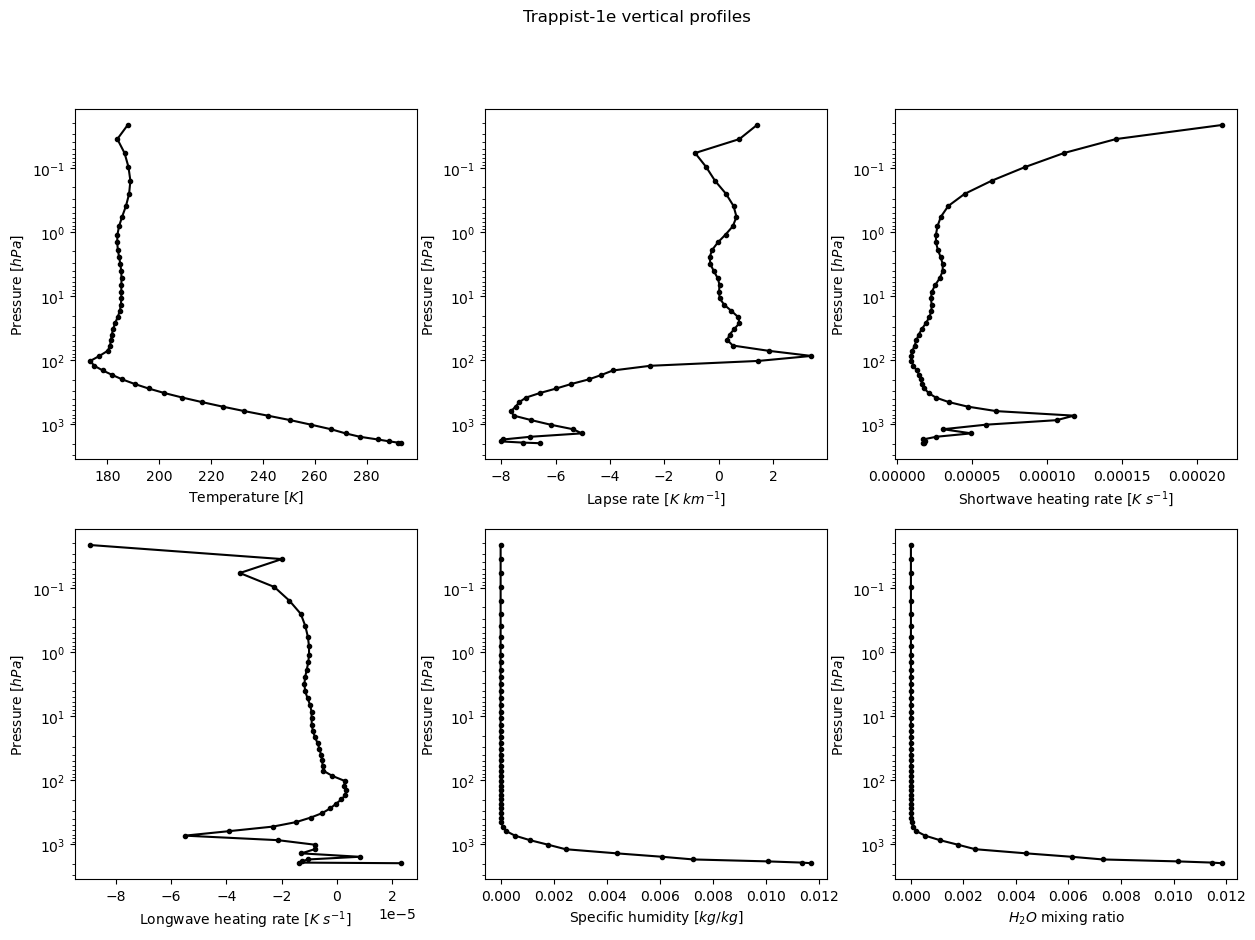

In [8]:
# Create matplotlib figure with axes
fig, axs = libs.utils.create_figure(
    shape=(2, 3), # Figure with 2x3 grid of subfigures
    height=5,     # Subfigure has height of '5'
    width=5       # Subfigure has width of 5
)

# Loop over the dictionary `confs_vertical_variables`
# and plot each variable on a subfigure
for i, key in enumerate(confs_vertical_variables):
    # Select axis and variable config
    ax = axs[i]
    conf_var = confs_vertical_variables[key]
    
    # Call plotting function, passing in:
    # - the data
    # - axis to plot on
    # - some keyword arguments for the plotting function
    # - and the config to extract the variable
    plot_atm_profile(
        gcm_slice,
        ax=ax,
        plot_kwargs={
            'color': '#000',
            'label': f'',
            'marker': '.'
        },
        **conf_var
    )

# Set figure title
fig.suptitle('Trappist-1e vertical profiles');

### 1x1 Temperature profiles for different longitudes

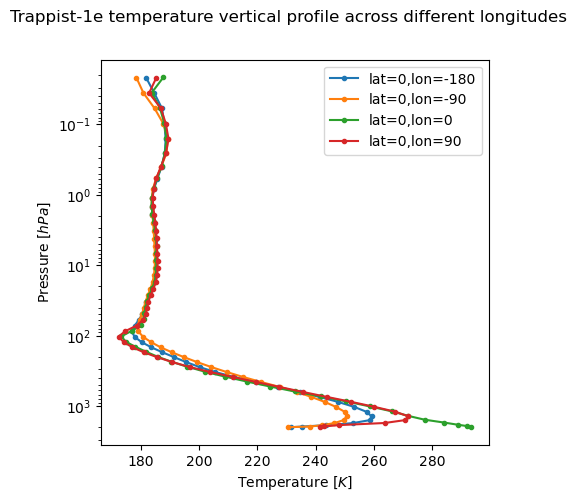

In [9]:
# Create matplotlib figure with axes
fig, axs = libs.utils.create_figure(
    shape=(1, 1), # Figure with 1x1 subfigures
    height=5,     # Subfigure has height of '5'
    width=5       # Subfigure has width of 5
)

confs_longitudes = [-180, -90, 0, 90]

# Loop over list of longitudes
for i, lon in enumerate(confs_longitudes):
    # Extract the data at that longitude (and 0 latitude)    
    gcm_lon_slice = gcm_data\
        .sel(time=slice('0012-01-01', '0015-01-01'))\
        .mean('time')\
        .sel(lat=0, lon=lon, method='nearest')

    # Call plotting function, passing in:
    # - the data
    # - axis to plot on (note we use the same axis here)
    # - some keyword arguments for the plotting function
    # - and the config to extract the variable
    plot_atm_profile(
        gcm_lon_slice,
        ax=axs[0],
        plot_kwargs={
            'label': f'lat=0,lon={lon}',
            'marker': '.'
        },
        update_axes=(i == 0), # Only update axes on first iteration
        **confs_vertical_variables['temperature']
    );

# Set figure title
fig.suptitle('Trappist-1e temperature vertical profile across different longitudes');

# Show legend with different plot labels
axs[0].legend()

### 1x1 Temperature profile for latitudinally-averaged longitude slice

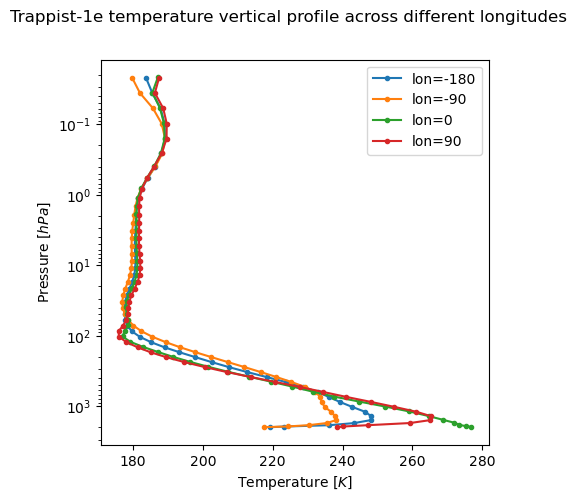

In [10]:
# Create matplotlib figure with axes
fig, axs = libs.utils.create_figure(
    shape=(1, 1), # Figure with 1x1 subfigures
    height=5,     # Subfigure has height of '5'
    width=5       # Subfigure has width of 5
)

confs_longitudes = [-180, -90, 0, 90]

# Loop over list of longitudes
for i, lon in enumerate(confs_longitudes):
    # Extract the data at that longitude (and 0 latitude)
    # Instead of selecting 0 latitude, we take a weighted
    # mean across latitude, and then select the longitude
    gcm_lon_slice = gcm_data\
        .sel(
            lon=lon,
            time=slice('0012-01-01', '0015-01-01')
        )\
        .mean('time')\
        .gcm_data.weighted_lat()\
        .mean('lat')

    # Call plotting function, passing in:
    # - the data
    # - axis to plot on (note we use the same axis here)
    # - some keyword arguments for the plotting function
    # - and the config to extract the variable
    plot_atm_profile(
        gcm_lon_slice,
        ax=axs[0],
        plot_kwargs={
            'label': f'lon={lon}',
            'marker': '.'
        },
        update_axes=(i == 0), # Only update axes on first iteration
        **confs_vertical_variables['temperature']
    );

# Set figure title
fig.suptitle('Trappist-1e temperature vertical profile across different longitudes');

# Show legend with different plot labels
axs[0].legend()